## Package Import

In [40]:
# Data Manipulation and Visualization
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sn
import numpy as np

# Factor Analysis
# pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

# Clustering
from sklearn.cluster import KMeans
# conda install -c conda-forge scikit-learn-extra
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from operator import itemgetter

# Classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

## Dataset Creation
The primary dataframe we will be working with is df_fct, which is a dataframe composed of only the 36 factor variables.

In [41]:
# Create dataframe from customer_data file
df = pd.read_csv('customer_data.csv')

# Create dataframe of factors only
df_fct =  df.drop(['UID','Const'], axis=1)

# Number of variables/factors/stimuli
variables_to_examine = len(df_fct.columns)

# scores = df_fct   # Run this instead of FA cell below to cluster/classify w/out FA

## Factor Analysis

The purpose of the factor analysis, as opposed to just clustering on the raw customer data, is to reduce noise in the initial dataset and hopefully obtain factors that are more generalizable to future, unseen data.

The variables are all on a similar scale, so we will use the covariance matrix for identifying principal components.

In [42]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=variables_to_examine, rotation=None)
fa.fit(df_fct)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()

# Create FactorAnalyzer object
n_factors = sum(i >= 1 for i in ev)
fa = FactorAnalyzer(n_factors=n_factors, rotation=None)

# Fit factor analysis model to variables
fa.fit(df_fct)

# Scores for the factor analysis, converted to dataframe
scores = pd.DataFrame(fa.transform(df_fct))


#################################
# Extra Stuff (Exclude from app)
#################################

# The loadings are the coefficients that make up the linear combination of original variables to get the factors (v1 = l1x1 + l2X2)
loadings = fa.loadings_

# Create dataframe of eigenvalues of the covariance matrix

data = {'factor'                    : range(1,n_factors+1),
        'eigenvalues'               : fa.get_eigenvalues()[0][0:n_factors],
        'common_factor_eigenvalues' : fa.get_eigenvalues()[1][0:n_factors],
        'variance'                  : fa.get_factor_variance()[0],
        'proportional_variance'     : fa.get_factor_variance()[1],
        'cumulative_variance'       : fa.get_factor_variance()[2]
       }

cov_matrix_eigenvals = pd.DataFrame(data=data).set_index('factor')

### Clustering

In [43]:
sw=[]

for i in range(2,7):
    
    # Create clustering objects
    cls1 = KMeans(n_clusters=i, random_state=0)
    cls2 = KMedoids(n_clusters=i, random_state=0)
    cls3 = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage ='ward')
        # Note on agglomerative clustering: if linkage is ward, affinity must be Euclidean
    cls_algs = [['kMeans', cls1], ['kMedoids', cls2], ['Hierarchical', cls3]]
    
    # Fit and score clustering solutions for i clusters with each clustering algorithm
    for cls in cls_algs:
        
        # Fit the model to the factor analysis scores
        cls[1].fit(scores)
        
        # List of assigned clusters
        clusters = cls[1].fit_predict(scores)
        
        # Silhouette scores for each solution
        silhouette_avg = silhouette_score(scores,clusters)
        
        # Store solution info [algorithm, number of clusters, avg silhouette score, cluster predictions]
        algorithm = cls[0]
        i_stats = [algorithm, i, silhouette_avg, clusters]
        sw.append(i_stats)
        
        # Add columns of cluster assignments to df_fct datafram
        df_fct[algorithm+'_'+'cluster'+'_'+str(i)] = clusters


# Reorder cluster lists by descending silhouette scores.  Clusters in first element should be assigned to training data.
sw = sorted(sw, key=itemgetter(2), reverse=True)

# Add the labels to the training dataset (you can ignore the warning when the cell runs)
df_fct['cluster'] = sw[0][3]

### Classification

#### Split into training, validation, and test data

In [44]:
# These are the variable columns and the optimal cluster assignment
data_of_interest = df_fct.iloc[:,np.r_[:variables_to_examine,-1]]

# Split data into 75% training, 12.5% validation, 12.5% test
train, valid = train_test_split(data_of_interest, test_size=0.25, random_state=123)

valid, test = train_test_split(valid, test_size=0.5, random_state=123)

# X is unlabeled training data, y is true training labels 
X, y = train.loc[:, train.columns != 'cluster'], train['cluster']

X_valid, y_valid = valid.loc[:, train.columns != 'cluster'], valid['cluster']

X_test, y_test = test.loc[:, test.columns != 'cluster'], test['cluster']

#### Classifier Loop

In [45]:
clf_scores = []

clf1 = RandomForestClassifier(random_state=0)
clf2 = GradientBoostingClassifier(random_state=0)
clf3 = SVC(random_state=0)
clf4 = KNeighborsClassifier()

classifiers = [['rf', clf1], ['gbt', clf2], ['svc', clf3], ['knn', clf4]]

for classifier in classifiers:
    
    # Fit classifier to training data
    classifier[1].fit(X,y)    
    
    # Store classifier-specific results [algorithm object, classifier name, scores]
    results = [classifier[1], classifier[0], classifier[1].score(X_valid,y_valid)]

    # Overall classifier results
    clf_scores.append(results)

# Sort classifier accuracy in descending order
clf_scores = sorted(clf_scores, key=itemgetter(1), reverse=True)    

#### View feature importance

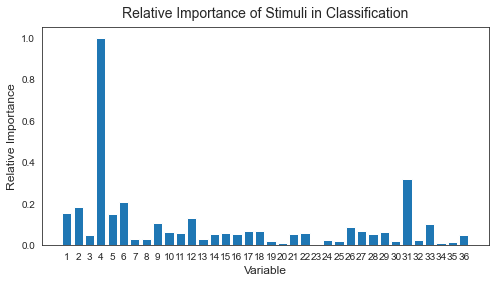

In [37]:
importance = pd.DataFrame({'variable': list(range(1,37)),
                           'rf': clf1.feature_importances_,
                           'gbt': clf2.feature_importances_,})

# Average variable importance of rf and gbt models
importance['avg'] = (importance['rf']+importance['gbt'])/2

# Put the average importances on a scale from 0 to 1 to make it easier to visualize
importance['Relative Importance'] = np.interp(importance['avg'], (importance['avg'].min(), importance['avg'].max()), (0, 1))

# View top 10 variables when RF and GBT models are averaged
top_10_avg = importance.sort_values(by='avg', ascending=False)[['avg', 'Relative Importance']].head(10)

# 7 out of 10 of the top variables appear in both lists

# Add variable rank column to dataframe
importance_rank = list(range(1,37))
importance = importance.sort_values(by='Relative Importance', ascending=False)
importance['rank'] = importance_rank
importance.reset_index(inplace=True)

# Visualize relative importance of stimuli
fig, ax = plt.subplots(figsize=(8,4))

ax.bar(x=importance.variable, height=importance['Relative Importance'], tick_label=importance.variable)
plt.xlabel("Variable", fontsize=12)
plt.ylabel("Relative Importance", fontsize=12)
plt.title("Relative Importance of Stimuli in Classification", fontsize=14, pad=10)
plt.savefig('relative_importance.png')
plt.show()

### Testing final accuracy of model with selected best model

In [38]:
# Changes dataset into 0s and 1s depending on the value of the cell
X_test_zero_one = X_test.mask(data_of_interest > 0, 1).mask(data_of_interest <= 0, 0)

# Raw data accuracy = 0.9056603773584906
print(f'Raw data: {round(clf_scores[0][0].score(X_test,y_test),5)*100}% accuracy')

# Binary variables accuracy = 0.7358490566037735
print(f'Binary variables: {round(clf_scores[0][0].score(X_test_zero_one,y_test),5)*100}% accuracy')

# That seems like a pretty significant difference

Raw data: 90.566% accuracy
Binary variables: 73.585% accuracy


## Model Quality: Target Shuffling

We decided to use target shuffling to assess the quality of the classification model.  The final model results are compared to scores for 10,000 random shuffles of the target variable, with the resulting difference charted in the histogram below.

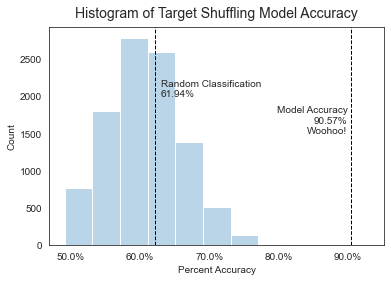

In [39]:
# Create a list of the scores for the model and the shuffles
accuracy_dist = []

# Accuracy score for the true raw data
accuracy_dist.append(round(clf_scores[0][0].score(X_test,y_test),5)*100)

# Loop shuffles the target variable and scores the model on that shuffle
for i in range(10000):
    shuffled_target = y_test.sample(frac=1)
    accuracy_dist.append(round(clf_scores[0][0].score(X_test,shuffled_target),3)*100)

# Create histogram of target shuffling model accuracy
fig, ax = plt.subplots()

sn.set_style('white')

ax = sn.histplot(accuracy_dist, binwidth=4, alpha=0.3)
plt.xlabel("Percent Accuracy")
plt.title("Histogram of Target Shuffling Model Accuracy", fontsize=14, pad=10)
ax.xaxis.set_major_formatter(PercentFormatter())
plt.axvline(90.566, linestyle='dashed', linewidth=1, color='k')
plt.text(90, 1500, f'Model Accuracy\n{round(accuracy_dist[0],2)}%\nWoohoo!', ha='right')
plt.axvline(62.2, linestyle='dashed', linewidth=1, color='k')
plt.text(63, 2000, f'Random Classification\n{round(np.mean(accuracy_dist[1:]),2)}%', ha='left')
plt.savefig('target_shuffling_accuracy.png')

plt.show()